# Predictor

This notebook shows how we created a predictor model that, given a csv file with data on the top 100 songs from previous years, will predict the song from 2017 most likely to be the next most popular song. In addition, this notebook shows how we created a barplot that compares the features of the predicted song with the average features of the chosen year.

Install the datascience library, and import it along with the numpy and csv libraries. Import the warnings library, to ignore unnecessary warnings that pop up when plotting, and the matplotlib library to make those plots.

In [2]:
! pip install datascience

from datascience import *
import numpy as np
import csv

import warnings
warnings.simplefilter("ignore", FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

Read in the csv file that contains data of songs and their features into a table.

In [3]:
data_2017 = Table.read_table("top_songs_2017.csv")
data_2017

song,artist,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
How Far I'll Go,Auli'i Cravalho,6mb6lVLNrcUgLnEN8QnDJd,0.576,0.319,4,-10.934,1,0.0518,0.603,0,0.173,0.0921,83.632,163387,4
Black SpiderMan,Logic feat. Damian Lemar Hudson,7BKUWh5sdtdS17crohRe4L,0.617,0.869,1,-5.293,1,0.101,0.132,7.38e-05,0.441,0.331,139.994,331267,4
You're Still My Sugar,Maddie Ross,4xHvcF6L3F4rtdyFKEkr4X,0.705,0.806,8,-4.904,0,0.052,0.0197,0.00107,0.0907,0.565,119.982,214012,4
Second One to Know,Chris Stapleton,0oTGa77jJ1H5joTG5SvxFj,0.527,0.893,0,-6.061,0,0.0396,0.0244,0.000753,0.343,0.892,96.73,176067,4
Love,Lana Del Rey,2Kerz9H9IejzeIpjhDJoYG,0.32,0.376,10,-10.885,1,0.033,0.451,0.00198,0.11,0.225,98.132,272743,4
Ella,Ricardo Arjona,7hydwXc3IVJIItIif6ZuLH,0.335,0.763,9,-3.853,1,0.0562,0.0307,0.000106,0.0758,0.403,199.225,198040,4
iSpy,Kyle feat. Lil Yachty,2EEeOnHehOozLq4aS0n6SL,0.746,0.653,7,-6.745,1,0.289,0.378,0,0.229,0.672,75.016,253107,4
Most Girls,Hailee Steinfeld,10GJQkjRJcZhGTLagFOC62,0.76,0.588,9,-7.082,1,0.0775,0.0485,0,0.0847,0.384,102.974,204400,4
Down,Marian Hill,5eCkuGPZNl4mISFNPgr3Dd,0.597,0.357,3,-14.718,1,0.259,0.644,0.00393,0.125,0.059,84.864,197773,4
Don't Kill My Vibe,Sigrid,2IOViM71uj8xksoqLb8TCm,0.544,0.755,10,-4.864,1,0.106,0.248,0.000156,0.244,0.289,150.013,184320,4


The data currently has features that range in scale. For instance, danceability ranges from 0 to 1, while loudness ranges from -60 to 0. If the features were plotted, some would carry more weight than others. To fix this problem, create a `rescale()` function that takes in a table and rescales the columns depending on the feature, such that the highest value in each column is 1. Key will need to be divided by 100, tempo will need to be divided by 1000, and so forth.

In [4]:
def rescale(table):
    table = table.with_columns(
        "rescaled_key", table.column("key") / 100,
        "rescaled_loudness", table.column("loudness") / 100,
        "rescaled_mode", table.column("mode") / 10,
        "rescaled_tempo", table.column("tempo") / 1000,
        "rescaled_duration_ms", table.column("duration_ms") / 1000000,
        "rescaled_time_signature", table.column("time_signature") / 10
    ).drop("key", "loudness", "mode", "tempo", "duration_ms", "time_signature")
    return table

rescale(data_2017)

song,artist,id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,rescaled_key,rescaled_loudness,rescaled_mode,rescaled_tempo,rescaled_duration_ms,rescaled_time_signature
How Far I'll Go,Auli'i Cravalho,6mb6lVLNrcUgLnEN8QnDJd,0.576,0.319,0.0518,0.603,0,0.173,0.0921,0.04,-0.10934,0.1,0.083632,0.163387,0.4
Black SpiderMan,Logic feat. Damian Lemar Hudson,7BKUWh5sdtdS17crohRe4L,0.617,0.869,0.101,0.132,7.38e-05,0.441,0.331,0.01,-0.05293,0.1,0.139994,0.331267,0.4
You're Still My Sugar,Maddie Ross,4xHvcF6L3F4rtdyFKEkr4X,0.705,0.806,0.052,0.0197,0.00107,0.0907,0.565,0.08,-0.04904,0,0.119982,0.214012,0.4
Second One to Know,Chris Stapleton,0oTGa77jJ1H5joTG5SvxFj,0.527,0.893,0.0396,0.0244,0.000753,0.343,0.892,0,-0.06061,0,0.09673,0.176067,0.4
Love,Lana Del Rey,2Kerz9H9IejzeIpjhDJoYG,0.32,0.376,0.033,0.451,0.00198,0.11,0.225,0.1,-0.10885,0.1,0.098132,0.272743,0.4
Ella,Ricardo Arjona,7hydwXc3IVJIItIif6ZuLH,0.335,0.763,0.0562,0.0307,0.000106,0.0758,0.403,0.09,-0.03853,0.1,0.199225,0.19804,0.4
iSpy,Kyle feat. Lil Yachty,2EEeOnHehOozLq4aS0n6SL,0.746,0.653,0.289,0.378,0,0.229,0.672,0.07,-0.06745,0.1,0.075016,0.253107,0.4
Most Girls,Hailee Steinfeld,10GJQkjRJcZhGTLagFOC62,0.76,0.588,0.0775,0.0485,0,0.0847,0.384,0.09,-0.07082,0.1,0.102974,0.2044,0.4
Down,Marian Hill,5eCkuGPZNl4mISFNPgr3Dd,0.597,0.357,0.259,0.644,0.00393,0.125,0.059,0.03,-0.14718,0.1,0.084864,0.197773,0.4
Don't Kill My Vibe,Sigrid,2IOViM71uj8xksoqLb8TCm,0.544,0.755,0.106,0.248,0.000156,0.244,0.289,0.1,-0.04864,0.1,0.150013,0.18432,0.4


After rescaling, create a `find_averages()` function that will go through each column in the table, starting with the first feature, and take the column's average. It should return an array that contains the averages for each feature in order. Be sure to use `rescale()` to properly format the data.

In [5]:
def find_averages(csv):
    table = Table.read_table(csv)
    table = table.drop(0, 1, 2)
    table = rescale(table)
    averages = []
    for i in np.arange(0, table.num_columns):
        averages = np.append(averages, np.nanmean(table.column(i)))
    return averages

find_averages("top_songs_2016.csv")

array([ 0.66189   ,  0.628465  ,  0.119507  ,  0.180886  ,  0.00438409,
        0.176729  ,  0.451382  ,  0.0597    , -0.0642864 ,  0.05      ,
        0.12055346,  0.22105077,  0.397     ])

Then, create a `find_difference()` function that, given a song and an array of averages to compare with, will find the difference between the song's features and the averages array. For each of the song's features, it should take the absolute difference between that feature and that feature's average in the averages array, and then sum up the total differences.

In [6]:
def find_difference(song, averages):
    song = song.drop(0, 1, 2)
    song = rescale(song)
    features = []
    for i in np.arange(0, song.num_columns):
        features = np.append(features, song.column(i))
    difference = sum(abs(features - averages))
    return difference

# data_2017.take(0) is "How Far I'll Go"
find_difference(data_2017.take(0), find_averages("top_songs_2016.csv"))

1.4649099200000002

Now that we have all the necessary functions, we can create `predictor()` which will take in the table of 2017 songs and a csv file of a year to compare it to. Use `find_averages()` on the inputted csv to obtain the array of averages that we will compare with. Using a for loop, go through each song in the table and use `find_difference()` to find the total difference between that song and the averages, and save these differences in a list. Then, add a differences column to the table with the calculated differences. Find the minimum difference, and return the table with the song that has the minimum difference. This song is the predicted most popular song, as it is the least different from the comparison dataset.

In [10]:
def predictor(table, csv):
    averages = find_averages(csv)
    differences = []
    for i in np.arange(0, table.num_rows):
        differences = np.append(differences, find_difference(table.item(i), averages))
    table = table.with_column("difference", differences)
    min_difference = min(table.column("difference"))
    return table.where("difference", are.equal_to(min_difference))

# csv files are "top_songs_2012.csv", "top_songs_2013.csv", "top_songs_2014.csv", "top_songs_2015.csv", "top_songs_2016.csv"
predictor(data_2017, "top_songs_2016.csv")

song,artist,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,difference
Stay,Zedd & Alessia Cara,6uBhi9gBXWjanegOb2Phh0,0.457,0.627,5,-5.091,0,0.111,0.238,0,0.116,0.554,101.384,210091,4,0.545913


Now that we have our `predictor()` function, we can plot the predicted song's features along with the comparison dataset's average features. Create `plot_comparison()` that will take in the 2017 table and the comparison csv file. It should use `predictor()` to obtain the predicted song. Save the song title, and save the year from the csv filename. Drop the non-numeric columns from the song table and rescale it with `rescale()`. Find the averages of the csv file with `find_averages()`. Create a new table to be plotted, and with a for loop, add a column to the plot table for each feature in the song table. Each column in the plot table should contain an array of the song feature value and the average feature value. In the end, the plot table should have columns for each feature, and it should have two rows, the first being a row of the song features, and the second being a row of the average features. With this table, add a "comparison" column with an array of the song title and the comparison year. Plot this table with `barh()` by the comparison column, such that the song and year are the categories, and their features are plotted as bars.

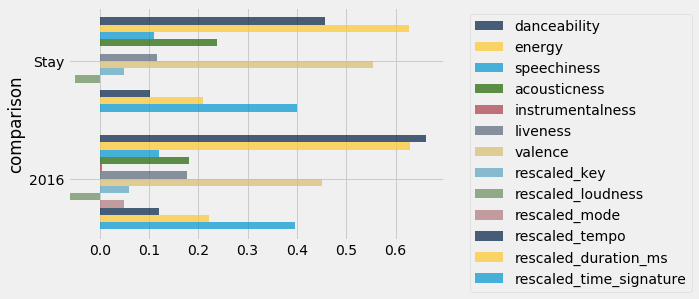

In [13]:
def plot_comparison(table, csv):
    song = predictor(table, csv)
    title = song.column("song").item(0)
    year = csv[10:14]
    song = rescale(song.drop("song", "artist", "id", "difference"))
    avg = find_averages(csv)
    table_plot = Table()
    for i in np.arange(0, song.num_columns):
        table_plot = table_plot.with_columns(
            song.labels[i], make_array(song.column(i).item(0), avg[i])
        )
    table_plot = table_plot.with_column("comparison", make_array(title, year))
    return table_plot.barh("comparison")

plot_comparison(data_2017, "top_songs_2016.csv")